In [7]:
# 📦 Imports & Settings
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Fixed random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [8]:
# 📄 File Paths (update as needed)
CSV_PATH = "datasets/education_policies.csv"
TRAIN_PATH = "train_education_policies.csv"
TEST_PATH = "test_education_policies.csv"

In [9]:
# 🔄 Preprocessing Function
def preprocess_education_data(df):
    df = df.copy()
    df = df.fillna("")
    
    # Standardize text fields
    for col in ['title', 'sector', 'region', 'target_group', 'status', 'stakeholders']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.title()
    
    df["funding_million_usd"] = pd.to_numeric(df["funding_million_usd"], errors="coerce").round(2)
    df["impact_score"] = pd.to_numeric(df["impact_score"], errors="coerce").round(3)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype('Int64')
    
    # Combined rich text for retrieval/NLP
    df["text_for_nlp"] = (
        "Policy ID: " + df["policy_id"].astype(str) +
        ". Title: " + df["title"].astype(str) +
        ". Sector: " + df["sector"].astype(str) +
        ". Region: " + df["region"].astype(str) +
        ". Year: " + df["year"].astype(str) +
        ". Target Group: " + df["target_group"].astype(str) +
        ". Status: " + df["status"].astype(str) +
        ". Funding: $" + df["funding_million_usd"].astype(str) + "M USD" +
        ". Impact Score: " + df["impact_score"].astype(str) +
        ". Stakeholders: " + df["stakeholders"].astype(str) +
        ". Summary: " + df["summary"].astype(str) +
        ". Goals: " + df["goals"].astype(str) +
        ". Full Description: " + df["full_text"].astype(str)
    ).str.lower()
    
    # Optional: Additional feature engineering
    df["funding_category"] = pd.cut(
        df["funding_million_usd"], bins=[0, 1, 5, 20, 100], 
        labels=["Low", "Medium", "High", "Very High"], include_lowest=True)
    df["impact_category"] = pd.cut(
        df["impact_score"], bins=[0, 0.3, 0.5, 0.7, 1.0], 
        labels=["Low Impact", "Medium Impact", "High Impact", "Very High Impact"], include_lowest=True)
    df["summary_word_count"] = df["summary"].astype(str).apply(lambda x: len(x.split()))
    df["goals_word_count"] = df["goals"].astype(str).apply(lambda x: len(x.split()))
    df["fulltext_word_count"] = df["full_text"].astype(str).apply(lambda x: len(x.split()))
    df["total_text_length"] = df["summary_word_count"] + df["goals_word_count"] + df["fulltext_word_count"]
    return df

In [10]:
# 🧮 Stratified Train-Test Split Function
def create_stratified_split(df, test_size=0.2, stratify_cols=None):
    if stratify_cols is None:
        stratify_cols = ["sector", "status"]
    stratify_column = df[stratify_cols].apply(lambda x: "_".join(x.astype(str)), axis=1)
    value_counts = stratify_column.value_counts()
    valid_groups = value_counts[value_counts >= 2].index
    df_valid = df[stratify_column.isin(valid_groups)].copy()
    df_remainder = df[~stratify_column.isin(valid_groups)].copy()
    if len(df_valid) > 0:
        train_valid, test_valid = train_test_split(
            df_valid, test_size=test_size, random_state=RANDOM_SEED, 
            stratify=stratify_column[stratify_column.isin(valid_groups)], shuffle=True
        )
        if len(df_remainder) > 0:
            train_rem, test_rem = train_test_split(df_remainder, test_size=test_size, random_state=RANDOM_SEED, shuffle=True)
            train_df = pd.concat([train_valid, train_rem], ignore_index=True)
            test_df = pd.concat([test_valid, test_rem], ignore_index=True)
        else:
            train_df, test_df = train_valid, test_valid
    else:
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=RANDOM_SEED, shuffle=True)
    return train_df, test_df


In [11]:
# 📋 Dataset Summary Function
def print_dataset_summary(df, name="Dataset"):
    print(f"\n📊 {name} Summary:")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print("\n🏷️ Key Categorical Distributions:")
    for col in ["sector", "status", "region"]:
        if col in df.columns:
            print(f"{col.title()}: {dict(df[col].value_counts().head(3))}")
    print("\n📈 Numeric Summary:")
    for col in ["year", "funding_million_usd", "impact_score"]:
        if col in df.columns:
            print(f"{col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")


In [12]:
# 🚦 Main Workflow
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    print(f"❌ {CSV_PATH} not found. Creating demo data...")
    # Minimal synthetic data for demonstration
    sample_data = {
        'policy_id': [f'P{1000+i}' for i in range(100)],
        'title': [f'Policy {i}' for i in range(100)],
        'sector': np.random.choice(['Higher Education', 'Primary', 'Secondary'], 100),
        'region': np.random.choice(['Delhi', 'Mumbai', 'Chennai'], 100),
        'year': np.random.choice(range(2015, 2026), 100),
        'target_group': np.random.choice(['Students', 'Teachers', 'Rural Students'], 100),
        'status': np.random.choice(['Proposed', 'Implemented', 'Under Review'], 100),
        'funding_million_usd': np.random.uniform(0.1, 50, 100),
        'impact_score': np.random.uniform(0.1, 1.0, 100),
        'stakeholders': ['Govt, NGOs'] * 100,
        'summary': ['Policy summary'] * 100,
        'goals': ['Policy goals'] * 100,
        'full_text': ['Full description'] * 100
    }
    df = pd.DataFrame(sample_data)
    print(f"✅ Created demo dataset: {df.shape[0]} rows, {df.shape[1]} columns")

✅ Loaded dataset: 500 rows, 13 columns


In [13]:
# ⏩ Data Preparation Steps
print_dataset_summary(df, "Original Dataset")
df_processed = preprocess_education_data(df)
print_dataset_summary(df_processed, "Processed Dataset")

print(f"\n📊 Creating stratified train-test split...")
train_df, test_df = create_stratified_split(df_processed, test_size=0.2, stratify_cols=["sector", "status"])

train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

print("\nTrain and test files saved!")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print_dataset_summary(train_df, "Training Set")
print_dataset_summary(test_df, "Test Set")


📊 Original Dataset Summary:
Shape: 500 rows, 13 columns
Missing values: 0
Duplicate rows: 0

🏷️ Key Categorical Distributions:
Sector: {'Higher Education': np.int64(113), 'Early Childhood': np.int64(102), 'Vocational': np.int64(97)}
Status: {'Proposed': np.int64(139), 'Implemented': np.int64(124), 'Pilot': np.int64(121)}
Region: {'Punjab': np.int64(63), 'Maharashtra': np.int64(62), 'Tamil Nadu': np.int64(56)}

📈 Numeric Summary:
year: mean=2020.17, std=3.12
funding_million_usd: mean=18.20, std=26.65
impact_score: mean=0.52, std=0.26

📊 Processed Dataset Summary:
Shape: 500 rows, 20 columns
Missing values: 0
Duplicate rows: 0

🏷️ Key Categorical Distributions:
Sector: {'Higher Education': np.int64(113), 'Early Childhood': np.int64(102), 'Vocational': np.int64(97)}
Status: {'Proposed': np.int64(139), 'Implemented': np.int64(124), 'Pilot': np.int64(121)}
Region: {'Punjab': np.int64(63), 'Maharashtra': np.int64(62), 'Tamil Nadu': np.int64(56)}

📈 Numeric Summary:
year: mean=2020.17, std=3

In [14]:
# -------------------------------------------------------
# TF-IDF Vectorization for Education Policy Dataset
# -------------------------------------------------------
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

MODEL_PATH = "education_policy_vectorizer.pkl"
MATRIX_PATH = "education_policy_tfidf_matrix.pkl"

# Step 1: Load datasets
train_df = pd.read_csv("train_education_policies.csv")
full_df = pd.read_csv("datasets/education_policies.csv")

# Step 2: Preprocess (ensure text_for_nlp exists)
def preprocess_policy_data(df):
    df = df.copy()
    df = df.fillna("")
    # Add/correct this block if your preprocessing hasn't run yet
    if "text_for_nlp" not in df.columns:
        df["text_for_nlp"] = (
            "policy id: " + df["policy_id"].astype(str) +
            ". title: " + df["title"].astype(str) +
            ". sector: " + df["sector"].astype(str) +
            ". region: " + df["region"].astype(str) +
            ". year: " + df["year"].astype(str) +
            ". target group: " + df["target_group"].astype(str) +
            ". status: " + df["status"].astype(str) +
            ". funding: $" + df["funding_million_usd"].astype(str) + "M USD" +
            ". impact score: " + df["impact_score"].astype(str) +
            ". stakeholders: " + df["stakeholders"].astype(str) +
            ". summary: " + df["summary"].astype(str) +
            ". goals: " + df["goals"].astype(str) +
            ". full description: " + df["full_text"].astype(str)
        ).str.lower()
    return df

train_df = preprocess_policy_data(train_df)
full_df = preprocess_policy_data(full_df)

# Step 3: Train TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(train_df["text_for_nlp"])

# Step 4: Transform full dataset
tfidf_matrix = vectorizer.transform(full_df["text_for_nlp"])

# Step 5: Save model and results
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump({"matrix": tfidf_matrix, "df": full_df}, MATRIX_PATH)

print(f"✅ Education Policy TF-IDF model saved to {MODEL_PATH} and {MATRIX_PATH}")


✅ Education Policy TF-IDF model saved to education_policy_vectorizer.pkl and education_policy_tfidf_matrix.pkl


TF-IDF matrix shape: (500, 3987), Sparsity: 3.56%
Top 20 words/phrases by TF-IDF importance:
and: 46.95
to: 42.03
policy: 22.41
learning: 21.88
strengthen: 21.83
improve: 21.34
monitoring: 21.15
education: 20.11
outcomes: 19.54
goals: 19.47
by: 19.25
community: 18.09
digital: 18.06
and community: 17.97
teachers: 17.66
aims: 17.55
aims to: 17.55
governance: 17.28
vocational: 17.26
urban: 17.21


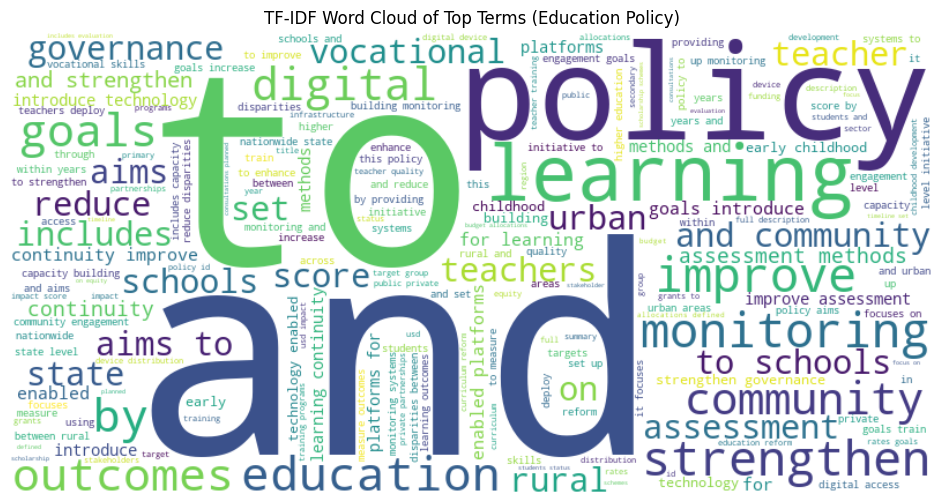

In [15]:
# -------------------------------------------------------
# TF-IDF Analysis & Visualization for Education Policy
# -------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import joblib

MATRIX_PATH = "education_policy_tfidf_matrix.pkl"
MODEL_PATH = "education_policy_vectorizer.pkl"

data = joblib.load(MATRIX_PATH)
tfidf_matrix = data["matrix"]
full_df = data["df"]
vectorizer = joblib.load(MODEL_PATH)

# 1. Sparsity
sparsity = 100.0 * (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# 2. Top 20 words/phrases
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]
print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# 3. Word Cloud
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms (Education Policy)")
plt.show()

In [17]:
# -------------------------------------------------------
# Education Policy Search using TF-IDF & Cosine Similarity
# -------------------------------------------------------
import textwrap
import joblib
from sklearn.metrics.pairwise import cosine_similarity

MODEL_PATH = "education_policy_vectorizer.pkl"
MATRIX_PATH = "education_policy_tfidf_matrix.pkl"

# Step 1: Load vectorizer and matrix
vectorizer = joblib.load(MODEL_PATH)
data = joblib.load(MATRIX_PATH)
tfidf_matrix = data["matrix"]
full_df = data["df"]

# Step 2: Search function (metadata-rich)
def search_policies(query, top_k=3, sector=None, region=None, status=None, year=None):
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    df_copy = full_df.copy()
    df_copy["similarity"] = sims
    # Optional filters
    if sector:
        df_copy = df_copy[df_copy["sector"].str.contains(sector, case=False, na=False)]
    if region:
        df_copy = df_copy[df_copy["region"].str.contains(region, case=False, na=False)]
    if status:
        df_copy = df_copy[df_copy["status"].str.contains(status, case=False, na=False)]
    if year:
        df_copy = df_copy[df_copy["year"].astype(str) == str(year)]
    top_records = df_copy.sort_values("similarity", ascending=False).head(top_k)
    results = []
    for _, row in top_records.iterrows():
        results.append({
            "Policy ID": row.get("policy_id", ""),
            "Title": row.get("title", ""),
            "Sector": row.get("sector", ""),
            "Region": row.get("region", ""),
            "Year": row.get("year", ""),
            "Target Group": row.get("target_group", ""),
            "Status": row.get("status", ""),
            "Funding (USD M)": row.get("funding_million_usd", ""),
            "Impact Score": row.get("impact_score", ""),
            "Stakeholders": row.get("stakeholders", ""),
            "Summary": row.get("summary", ""),
            "Goals": row.get("goals", ""),
            "Similarity": float(row["similarity"])
        })
    return results

# Step 3: Demo usage and pretty printing
query = "policy to support rural education with free materials"
top_matches = search_policies(query, top_k=3, sector="primary", region="uttar pradesh")

for i, res in enumerate(top_matches, 1):
    print("="*80)
    print(f"Result: {i}")
    print("-"*80)
    print(f"Policy ID        : {res['Policy ID']}")
    print(f"Title            : {res['Title']}")
    print(f"Sector           : {res['Sector']}")
    print(f"Region           : {res['Region']}")
    print(f"Year             : {res['Year']}")
    print(f"Target Group     : {res['Target Group']}")
    print(f"Status           : {res['Status']}")
    print(f"Funding (USD M)  : {res['Funding (USD M)']}")
    print(f"Impact Score     : {res['Impact Score']}")
    print(f"Stakeholders     : {res['Stakeholders']}")
    print(f"Summary          : {textwrap.shorten(str(res['Summary']), width=150)}")
    print(f"Goals            : {textwrap.shorten(str(res['Goals']), width=150)}")
    print(f"Similarity Score : {res['Similarity']:.3f}")
    print("="*80 + "\n")

Result: 1
--------------------------------------------------------------------------------
Policy ID        : P1068
Title            : District Secondary Education Reform 56
Sector           : Primary
Region           : Uttar Pradesh
Year             : 2022
Target Group     : Rural Students
Status           : Proposed
Funding (USD M)  : 0.12
Impact Score     : 0.433
Stakeholders     : EdTech Companies, Universities
Summary          : This policy aims to improve digital access in Primary by providing grants to schools across Uttar Pradesh. It focuses on rural accessibility.
Goals            : Increase digital access score by 11% within 3 years and reduce disparities between rural and urban areas.
Similarity Score : 0.124

Result: 2
--------------------------------------------------------------------------------
Policy ID        : P1130
Title            : National Vocational Education Reform 50
Sector           : Primary
Region           : Uttar Pradesh
Year             : 2022
Target Gro